### Plot term structures and credit spread

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from conda.instructions import PRINT

# NSS parameters from St-Louis Fed
beta0 = 3.385571197
beta1 = 0.938107702
beta2 = -7.40E-05
beta3 = 4.296030822
tau1 = 1.227066261
tau2 = 18.49221165

# Define NSS curve function
def nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1))
    term3 = beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1))
    term4 = beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2))
    return term1 + term2 + term3 + term4

# Observed AA yields
maturities = np.array([0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 30])
aa_yields = np.array([4.50, 4.53, 4.59, 4.66, 4.73, 4.81, 5.01, 5.28, 5.42, 5.55, 5.67, 5.77])

# Get treasury yields
risk_free_yields = nss_curve(maturities, beta0, beta1, beta2, beta3, tau1, tau2)

# Get credit spread
credit_spreads = aa_yields - risk_free_yields

# Store results
df_results = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Risk-Free Yield (%)': risk_free_yields.round(2),
    'AA Yield (%)': aa_yields,
    'Credit Spread (bps)': credit_spreads.round(4) * 100  # Convert to basis points
})

df_results

,Maturity (Years),Risk-Free Yield (%),AA Yield (%),Credit Spread (bps)
0,0.5,4.21,4.50,28.69
1,1.0,4.14,4.53,39.08
2,2.0,4.06,4.59,52.54
3,3.0,4.05,4.66,61.10
4,4.0,4.07,4.73,66.50
5,5.0,4.10,4.81,71.21
6,7.0,4.18,5.01,82.62
7,10.0,4.32,5.28,96.26
8,12.0,4.40,5.42,102.32
9,15.0,4.50,5.55,105.38


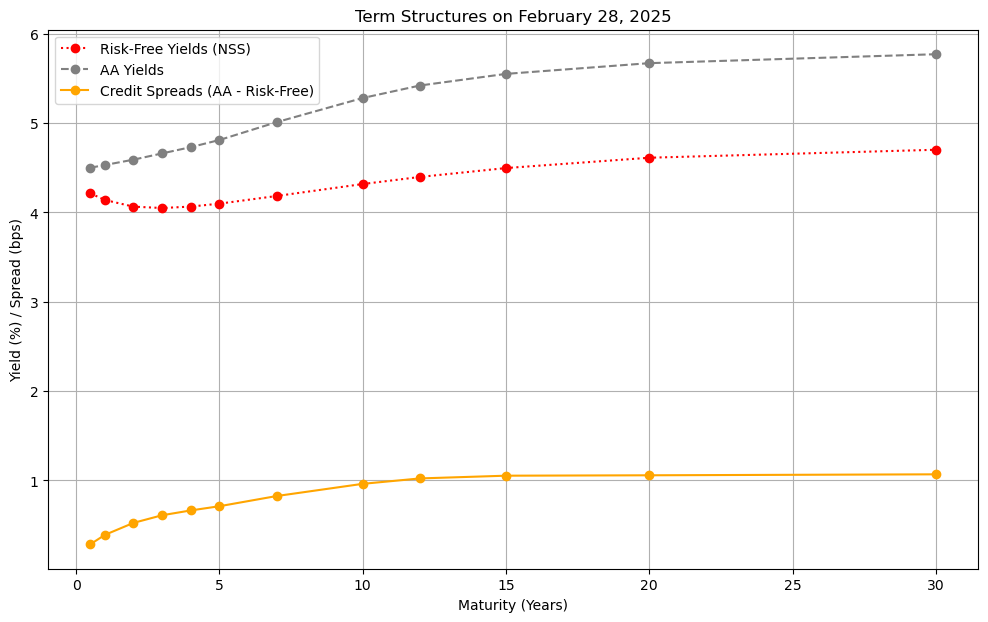

In [11]:

# Plot results
plt.figure(figsize=(12, 7))
plt.plot(maturities, risk_free_yields, label='Risk-Free Yields (NSS)', marker='o', color='r', linestyle=':')
plt.plot(maturities, aa_yields, label='AA Yields', marker='o', color='grey', linestyle='--')
plt.plot(maturities, credit_spreads, label='Credit Spreads (AA - Risk-Free)', marker='o', color='orange', linestyle='-')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%) / Spread (bps)')
plt.title('Term Structures on February 28, 2025')
plt.legend()
plt.grid(True)
plt.show()


### Calibrate the Duffee (1999) model 
To the observed treasury and AA yields .

In [12]:
# GET P(0,T) FOR EACH MATURITY
t = 0
df_results['Bond Price (P(0,T))'] = np.exp(-df_results['Risk-Free Yield (%)'] / 100 * df_results['Maturity (Years)'])

Calibrated Parameters:
r0: 0.0621
kappa_r: 0.9985
theta_r: 0.0167
sigma_r: 0.1996
s0: 0.0107
kappa_s: 0.0683
theta_s: 0.0388
sigma_s: 0.2092
alpha: 0.0281
beta: -0.7367


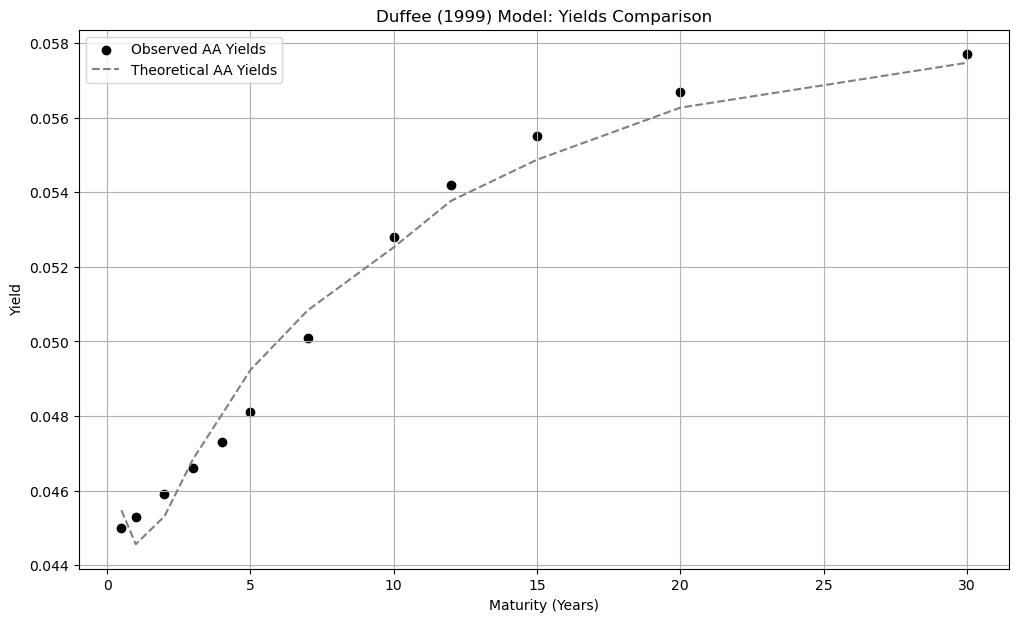

In [10]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


class DuffeeModel:
    def __init__(self, df_results):
        # Store observed market data
        self.maturities = df_results['Maturity (Years)'].values
        self.rf_yields = df_results['Risk-Free Yield (%)'].values / 100  # Convert to decimal
        self.aa_yields = df_results['AA Yield (%)'].values / 100  # Convert to decimal
        self.credit_spreads = df_results['Credit Spread (bps)'].values / 10000  # Convert to decimal
        self.bond_prices = df_results['Bond Price (P(0,T))'].values  # Bond prices

        # Initial parameter guesses
        self.r0 = np.mean(self.rf_yields)
        self.kappa_r = 0.1
        self.theta_r = self.r0
        self.sigma_r = 0.1

        # Credit spread parameters
        self.s0 = 0.01
        self.kappa_s = 0.1
        self.theta_s = 0.02
        self.sigma_s = 0.1
        self.alpha = 0.01
        self.beta = 0.5

    def calibrate(self):
        def objective(params):
            # Extract parameters
            r0, kappa_r, theta_r, sigma_r, s0, kappa_s, theta_s, sigma_s, alpha, beta = params

            # Compute theoretical risk-free yields using the CIR model
            theoretical_rf_yields = [r0 + (theta_r - r0) * (1 - np.exp(-kappa_r * t)) for t in self.maturities]

            # Compute theoretical credit spreads using the OU process
            theoretical_spreads = [s0 + (theta_s - s0) * (1 - np.exp(-kappa_s * t)) for t in self.maturities]

            # Compute the theoretical AA yields using the Duffee model
            theoretical_aa_yields = [
                (1 / t) * np.log(1 / (P+1e-8)) + alpha + beta * rf + spread
                for t, P, rf, spread in zip(self.maturities, self.bond_prices, theoretical_rf_yields, theoretical_spreads)
            ]

            # Calculate the sum of squared errors between observed and theoretical AA yields
            return np.sum((np.array(theoretical_aa_yields) - self.aa_yields) ** 2)

        # Initial guess for all parameters
        initial_guess = [self.r0, self.kappa_r, self.theta_r, self.sigma_r, self.s0, self.kappa_s, self.theta_s, self.sigma_s, self.alpha, self.beta]

        # Bounds for each parameter (for stability and physical meaning)
        bounds = [
            (0.0, 0.1),    # r0
            (0.0001, 1.0),  # kappa_r
            (0.0, 0.1),     # theta_r
            (0.0001, 0.5),  # sigma_r
            (0.0, 0.05),    # s0
            (0.0001, 1.0),  # kappa_s
            (0.0, 0.05),    # theta_s
            (0.0001, 0.5),  # sigma_s
            (0.0, 0.05),    # alpha
            (-1.0, 1.0)     # beta
        ]

        # Minimize the objective function to calibrate the model parameters
        result = optimize.minimize(objective, initial_guess, method='trust-constr', bounds=bounds)

        # Extract the optimized parameters
        self.r0, self.kappa_r, self.theta_r, self.sigma_r, self.s0, self.kappa_s, self.theta_s, self.sigma_s, self.alpha, self.beta = result.x

        # Print the calibrated parameters
        print("Calibrated Parameters:")
        print(f"r0: {self.r0:.4f}")
        print(f"kappa_r: {self.kappa_r:.4f}")
        print(f"theta_r: {self.theta_r:.4f}")
        print(f"sigma_r: {self.sigma_r:.4f}")
        print(f"s0: {self.s0:.4f}")
        print(f"kappa_s: {self.kappa_s:.4f}")
        print(f"theta_s: {self.theta_s:.4f}")
        print(f"sigma_s: {self.sigma_s:.4f}")
        print(f"alpha: {self.alpha:.4f}")
        print(f"beta: {self.beta:.4f}")

    def plot_calibration(self):
        """
        Plot observed vs theoretical yields
        """
        plt.figure(figsize=(12, 7))
        
        # Plot observed market AA yields
        plt.scatter(self.maturities, self.aa_yields, label='Observed AA Yields', color='black')

        # Compute theoretical AA yields using the calibrated parameters
        theoretical_rf_yields = [self.r0 + (self.theta_r - self.r0) * (1 - np.exp(-self.kappa_r * t)) for t in self.maturities]
        theoretical_spreads = [self.s0 + (self.theta_s - self.s0) * (1 - np.exp(-self.kappa_s * t)) for t in self.maturities]
        
        # Use the updated formula for Y(t,T) using the bond prices
        
        theoretical_aa_yields = [
            (-1 / T) * np.log(P) + self.alpha + self.beta * rf + spread
            for T, P, rf, spread in zip(self.maturities, self.bond_prices, theoretical_rf_yields, theoretical_spreads)
        ]
        
        # Smooth the theoretical AA yields for better visualization 
        # AVOIDS ABRUPT JUMPS WHEN P IS CLOSE TO ZERO
        theoretical_aa_yields = gaussian_filter1d(theoretical_aa_yields, sigma=1)

        # Plot theoretical AA yields
        plt.plot(self.maturities, theoretical_aa_yields, label='Theoretical AA Yields', color='grey', linestyle='--')
        
        plt.title('Duffee (1999) Model: Yields Comparison')
        plt.xlabel('Maturity (Years)')
        plt.ylabel('Yield')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
df_results = pd.DataFrame({
    'Maturity (Years)': [0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 30],
    'Risk-Free Yield (%)': [4.21, 4.14, 4.06, 4.05, 4.07, 4.10, 4.18, 4.32, 4.40, 4.50, 4.61, 4.70],
    'AA Yield (%)': [4.50, 4.53, 4.59, 4.66, 4.73, 4.81, 5.01, 5.28, 5.42, 5.55, 5.67, 5.77],
    'Credit Spread (bps)': [28.69, 39.08, 52.54, 61.10, 66.50, 71.21, 82.62, 96.26, 102.32, 105.38, 105.83, 106.90],
    'Bond Price (P(0,T))': [0.9801, 0.9750, 0.9600, 0.9500, 0.9400, 0.9300, 0.9100, 0.8800, 0.8700, 0.8600, 0.8400, 0.8000]
})

# Create the Duffee model and calibrate
model = DuffeeModel(df_results)
model.calibrate()
model.plot_calibration()

For the report, displaying purposes only.

In [2]:
import pandas as pd

# Calibrated parameters
params = {
    'r_t': {
        'r0': 0.0640,
        'kappa_r': 0.0683,
        'theta_r': 0.0268,
        'sigma_r': 0.3624
    },
    's_t': {
        's0': 0.0084,
        'kappa_s': 0.9980,
        'theta_s': 0.0418,
        'sigma_s': 0.3622
    },
    'other': {
        'alpha': 0.0330,
        'beta': -0.7544
    }
}

# Create DataFrames for r_t and s_t parameters
r_t_params = pd.DataFrame(list(params['r_t'].items()), columns=['Parameter', 'Value'])
s_t_params = pd.DataFrame(list(params['s_t'].items()), columns=['Parameter', 'Value'])

r_t_params

,Parameter,Value
0,s0,0.0084
1,kappa_s,0.9980
2,theta_s,0.0418
3,sigma_s,0.3622


In [3]:
s_t_params

,Parameter,Value
0,s0,0.0084
1,kappa_s,0.9980
2,theta_s,0.0418
3,sigma_s,0.3622


### Finite difference scheme

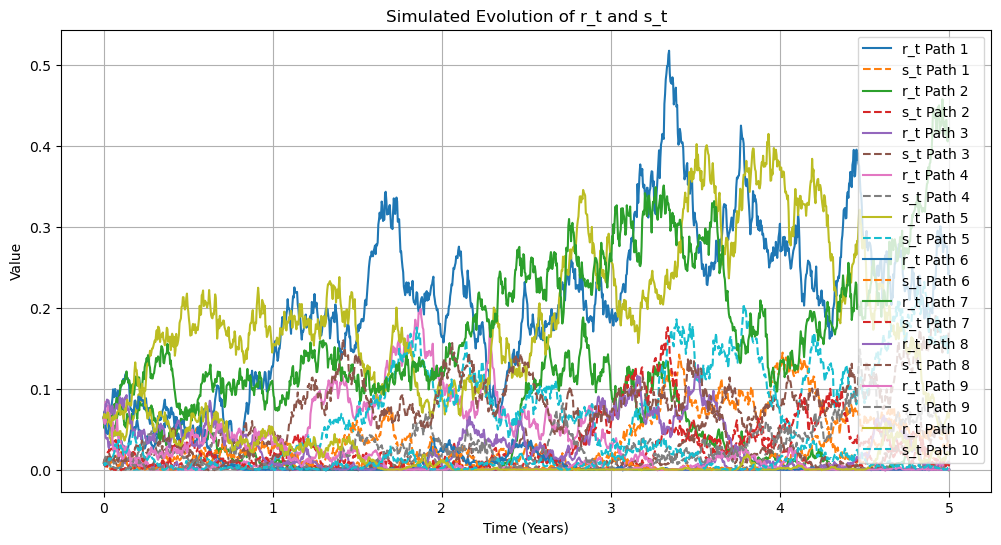

In [21]:
r0= 0.0640
kappa_r= 0.0683
theta_r= 0.0268
sigma_r= 0.3624
s0= 0.0084
kappa_s= 0.9980
theta_s= 0.0418
sigma_s= 0.3622
alpha= 0.0330
beta= -0.7544

T = 5  # maturity in years
dt = 1/252  # daily time step (assuming 252 trading days per year)
num_steps = int(T / dt)  # number of steps for the simulation
num_paths = 10  # number of simulation paths to visualize

# Initialize arrays to store the results
r_paths = np.zeros((num_paths, num_steps))
s_paths = np.zeros((num_paths, num_steps))

# Initial conditions
r_paths[:, 0] = r0
s_paths[:, 0] = s0

# Simulate the paths
for i in range(num_paths):
    for t in range(1, num_steps):
        # Generate random normal values for the two Brownian motions
        epsilon_r = np.random.normal(0, 1)
        epsilon_s = np.random.normal(0, 1)
        
        # Ensure r_t and s_t are non-negative before applying sqrt
        r_t = r_paths[i, t-1]
        s_t = s_paths[i, t-1]
        
        r_t = max(r_t, 0)  # Avoid negative values for r_t
        s_t = max(s_t, 0)  # Avoid negative values for s_t
        
        # Update the processes using Euler-Maruyama scheme
        r_paths[i, t] = r_t + kappa_r * (theta_r - r_t) * dt + sigma_r * np.sqrt(r_t * dt) * epsilon_r
        s_paths[i, t] = s_t + kappa_s * (theta_s - s_t) * dt + sigma_s * np.sqrt(s_t * dt) * epsilon_s

# Plot the results
plt.figure(figsize=(12, 6))

for i in range(num_paths):
    plt.plot(np.linspace(0, T, num_steps), r_paths[i], label=f"r_t Path {i+1}")
    plt.plot(np.linspace(0, T, num_steps), s_paths[i], label=f"s_t Path {i+1}", linestyle='--')

plt.title('Simulated Evolution of r_t and s_t')
plt.xlabel('Time (Years)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Bond parameters
nominal = 1_000_000  # Nominal value
coupon_rate = 0.04  # 4% annual coupon
freq = 2  # Semi-annual payments (2 times per year)
maturity = 5  # 5 years
call_price = nominal  # Callable at par
dt = 1/52  # Weekly time step

# Duffee model parameters (already calibrated)
kappa_r = 0.1
theta_r = 0.04
sigma_r = 0.02
r0 = 0.04
kappa_s = 0.2
theta_s = 0.01
sigma_s = 0.01
s0 = 0.005

# Time and grid setup
T = maturity
time_steps = int(T / dt)
times = np.linspace(0, T, time_steps + 1)

def simulate_paths(n_scenarios=1000):
    np.random.seed(42)
    r_paths = np.zeros((n_scenarios, time_steps + 1))
    s_paths = np.zeros((n_scenarios, time_steps + 1))
    r_paths[:, 0] = r0
    s_paths[:, 0] = s0
    
    for t in range(1, time_steps + 1):
        epsilon_r = np.random.normal(0, 1, n_scenarios)
        epsilon_s = np.random.normal(0, 1, n_scenarios)
        
        r_paths[:, t] = np.maximum(0, r_paths[:, t-1] + kappa_r * (theta_r - r_paths[:, t-1]) * dt + sigma_r * np.sqrt(np.maximum(r_paths[:, t-1], 1e-6) * dt) * epsilon_r)
        s_paths[:, t] = np.maximum(0, s_paths[:, t-1] + kappa_s * (theta_s - s_paths[:, t-1]) * dt + sigma_s * np.sqrt(np.maximum(s_paths[:, t-1], 1e-6) * dt) * epsilon_s)
    
    return r_paths, s_paths

def price_callable_bond(n_scenarios=1000):
    r_paths, s_paths = simulate_paths(n_scenarios)
    
    # Initialize bond price matrix
    P = np.full((n_scenarios, time_steps + 1), nominal)
    
    # Backward induction for pricing
    for t in range(time_steps - 1, -1, -1):
        discount = np.exp(-r_paths[:, t] * dt)
        coupon = (nominal * coupon_rate / freq) if (t % (1 / dt / freq) == 0) else 0
        next_P = P[:, t + 1]
        
        # Bond value before considering call
        bond_value = discount * (next_P + coupon)
        
        # Apply call feature
        P[:, t] = np.minimum(bond_value, call_price)
    
    # Return the mean price at t=0
    return np.mean(P[:, 0])

# Compute bond price
callable_bond_price = price_callable_bond()
print(f"Callable AA Bond Price at t=0: ${callable_bond_price:,.4f}")


Callable AA Bond Price at t=0: $992,525.7620


### yield-to-maturity on callable & non-callable bond

In [31]:
from scipy.optimize import fsolve

def yield_to_maturity(price, nominal, coupon_rate, maturity, freq):
    coupon = nominal * coupon_rate / freq
    
    def ytm_eqn(YTM):
        return sum(coupon * np.exp(-YTM * t) for t in np.arange(1/freq, maturity + 1/freq, 1/freq)) + nominal * np.exp(-YTM * maturity) - price
    
    YTM_solution = fsolve(ytm_eqn, 0.05)[0]  # Initial guess: 5%
    return YTM_solution

# Compute bond price
callable_bond_price = price_callable_bond()
print(f"Callable AA Bond Price at t=0: ${callable_bond_price:,.2f}")

# Compute YTM for the callable bond
ytm_callable = yield_to_maturity(callable_bond_price, nominal, coupon_rate, maturity, freq)
print(f"Callable Bond Yield-to-Maturity: {ytm_callable:.4%}")

# Compute YTM for a similar non-callable bond (assuming price is nominal value)
non_callable_price = nominal  # Non-callable assumed to be at par
ytm_non_callable = yield_to_maturity(non_callable_price, nominal, coupon_rate, maturity, freq)
print(f"Non-Callable Bond Yield-to-Maturity: {ytm_non_callable:.4%}")


Callable AA Bond Price at t=0: $992,525.76
Callable Bond Yield-to-Maturity: 4.1243%
Non-Callable Bond Yield-to-Maturity: 3.9605%
